In this tutorial, we will introduce how to use MMPretrain for a multi-label classification task. <br>
This approach is suitable for scenarios where an image may belong to two or more categories. <br>
However, if your dataset includes bounding box annotations, it is recommended to use object detection algorithms instead. <br>

# Install
We have MMpretrain installed for you when you see this page

# Start trying
Ensure you have selected the right kernel (on the top right corner of jupyter lab interface), the one you have just named <br>
now we change the directory to the installed location

In [1]:
cd mmpretrain

/home/test/carasml/classification/mm_Resnet/mmpretrain


/home/test/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Load a model

In [2]:
from mmpretrain.apis import list_models
from mmpretrain.apis import get_model
from mmpretrain.apis import inference_model

In [3]:
list_models(task='Multi-Label Classification')

['resnet101-csra_1xb16_voc07-448px']

In [4]:
#there is only one
model_name = 'resnet101-csra_1xb16_voc07-448px'
model = get_model(model_name, pretrained=True, device='cuda')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmclassification/v0/csra/resnet101-csra_1xb16_voc07-448px_20220722-29efb40a.pth


In [5]:
import torch
from PIL import Image
import numpy as np

# Set model to evaluation mode
model.eval()

# Load the image
image_path = 'demo/cat-dog.png' # replace with your image
with open(image_path, 'rb') as f:
    img = Image.open(f).convert('RGB')

# Preprocessing (resize to 448px as indicated in the model name)
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])
img_tensor = transform(img).unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU

# Run inference
with torch.no_grad():
    result = model(img_tensor, mode='predict')

# Process results
# The model outputs probabilities for each class
scores = result[0].pred_score.cpu().numpy()

# You can set a threshold to determine positive predictions
threshold = 0.5
predicted_labels = np.where(scores > threshold)[0] # Get indices of classes above threshold

# Get class names (if available in the model)
class_names = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
predicted_class_names = [class_names[idx] for idx in predicted_labels]
print("Predicted classes:", predicted_class_names)
scores = [scores[idx] for idx in predicted_labels]
print("Prediction scores:", scores)

Predicted classes: ['cat', 'dog']
Prediction scores: [np.float32(0.89869225), np.float32(0.62849027)]


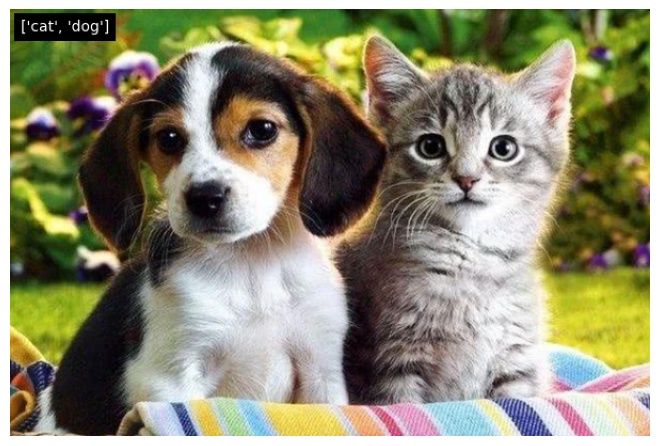

In [6]:
# plot it
import mmcv
from mmengine.visualization import Visualizer
import torch
image = mmcv.imread(image_path, channel_order='rgb')
pred_print = f'{predicted_class_names}'
visualizer = Visualizer(image=image)
visualizer.draw_texts(pred_print, torch.tensor([10, 10]), font_sizes=10, colors='white', bboxes=dict(facecolor='black', linewidth=0, alpha=1))
visualizer.show()

# Prepare dataset
We use VOC2007 as demo <br>
This tutorial we aim at demonstrating how to start with a dataset with labeled with Labelme, so we have converted the dataset to the annotation format when installing <br>
The dataset should be in below format

In [ ]:
Where the json is like
{
    "metainfo":
    {
      "classes":['A', 'B', 'C'....]
    },
    "data_list":
    [
      {
        "img_path": "test_img1.jpg",
        'gt_label': [0, 1],
      },
      {
        "img_path": "test_img2.jpg",
        'gt_label': [2],
      },
    ]
    ....
}

If your dataset is labeled by Labelme, you can run the below script to convert it to required format <br>
You can skip if you proceed with the given VOC2007 dataset

In [7]:
import os
import json

# Paths
src_dir = os.path.abspath("../input")
output_dir = os.path.abspath("../input")
os.makedirs(output_dir, exist_ok=True)

# Collect data
all_classes = set()
data_list = []

# Step 1: Parse JSONs and collect all classes
json_files = [f for f in os.listdir(src_dir) if f.endswith(".json")]

for fname in json_files:
    fpath = os.path.join(src_dir, fname)
    with open(fpath, 'r') as f:
        data = json.load(f)

    flags = data.get("flags", {})
    class_labels = [cls for cls, v in flags.items() if v is True]
    if not class_labels:
        continue

    all_classes.update(class_labels)

# Step 2: Create class-to-index mapping
all_classes = sorted(list(all_classes))
class_to_idx = {cls: i for i, cls in enumerate(all_classes)}

# Step 3: Reparse JSONs and convert to target format
for fname in json_files:
    fpath = os.path.join(src_dir, fname)
    with open(fpath, 'r') as f:
        data = json.load(f)

    flags = data.get("flags", {})
    labels = [class_to_idx[cls] for cls, v in flags.items() if v is True]
    if not labels:
        continue

    image_path = data.get("imagePath")
    if not image_path:
        continue

    item = {
        "img_path": image_path,
        "gt_label": labels  
    }
    data_list.append(item)

# Final output
unified = {
    "metainfo": {
        "classes": all_classes
    },
    "data_list": data_list
}

# Save the unified JSON
output_path = os.path.join(output_dir, "unified_dataset.json")
with open(output_path, 'w') as f:
    json.dump(unified, f, indent=2)

print(f"✅ Unified JSON saved to: {output_path}")

✅ Unified JSON saved to: /home/z890/Downloads/ml_sample_develop/carasml/classification/mm_Resnet/input/unified_dataset.json


# Train our model

In [7]:
# We need to set configs for our model
# First check what the default configs looks like
from mmengine import Config
# give the path of the configs of the model we choose
cfg = Config.fromfile('./configs/csra/resnet101-csra_1xb16_voc07-448px.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint = 'https://download.openmmlab.com/mmclassification/v0/resnet/resnet101_8xb32_in1k_20210831-539c63f8.pth'
data_preprocessor = dict(
    mean=[
        0,
        0,
        0,
    ],
    num_classes=20,
    std=[
        255,
        255,
        255,
    ],
    to_onehot=True,
    to_rgb=True)
dataset_type = 'VOC'
default_hooks = dict(
    checkpoint=dict(interval=1, type='CheckpointHook'),
    logger=dict(interval=100, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(enable=False, type='VisualizationHook'))
default_scope = 'mmpretrain'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
load_from = None
log_level = 'INFO'
model = dict(
    backbone=dict(
        depth=101,
        init_cfg=dict(
            checkpoint=
            'https://downl

Looks carefully in the configs, identify what need to be revised to fit our model <br>
the layer of 'dict' is chained by a '.' <br>
Here are the list that need to be revised: <br>
 <br>
dataset_type&nbsp;&nbsp;&nbsp;&nbsp;#change to MultiLabelDataset<br>
data_preprocessor.num_classes&nbsp;&nbsp;&nbsp;&nbsp;#we have 20<br>
model.head.num_classes&nbsp;&nbsp;&nbsp;&nbsp;#we have 20<br>
optim_wrapper.optimizer.lr&nbsp;&nbsp;&nbsp;&nbsp;#the default is for 8gpu, which maybe to large<br>
train_dataloader.dataset.data_root&nbsp;&nbsp;&nbsp;&nbsp;#our dataset directory<br>
train_dataloader.dataset.type&nbsp;&nbsp;&nbsp;&nbsp;#change to custom<br>
train_dataloader.batch_size&nbsp;&nbsp;&nbsp;&nbsp;#batch size that best utilize gpu<br>
train_dataloader.dataset.ann_file&nbsp;&nbsp;&nbsp;&nbsp;#the json<br>
val_dataloader.dataset.data_root <br>
val_dataloader.dataset.type <br>
val_dataloader.batch_size <br>
val_dataloader.dataset.ann_file <br>
test_dataloader.dataset.data_root <br>
test_dataloader.dataset.type <br>
test_dataloader.batch_size <br>
test_dataloader.dataset.ann_file <br>
 <br>
for configs explanation, you can refer to <br>
https://mmpretrain.readthedocs.io/en/stable/user_guides/config.html <br>

In [8]:
cfg.dataset_type = 'MultiLabelDataset'
cfg.data_preprocessor.num_classes = 20
cfg.model.head.num_classes = 20
cfg.optim_wrapper.optimizer.lr = cfg.optim_wrapper.optimizer.lr/8 #set it to default/8 maybe enough, you can increase if find it too small

cfg.train_dataloader.dataset.data_root = 'VOC2007/train'
cfg.train_dataloader.dataset.type = 'MultiLabelDataset'
cfg.train_dataloader.batch_size = 16
cfg.val_dataloader.dataset.data_root = 'VOC2007/test'
cfg.val_dataloader.dataset.type = 'MultiLabelDataset'
cfg.val_dataloader.batch_size = 16
cfg.test_dataloader.dataset.data_root = 'VOC2007/test'
cfg.test_dataloader.dataset.type = 'MultiLabelDataset'
cfg.test_dataloader.batch_size = 16

cfg.train_dataloader.dataset.ann_file = 'voc_annotations_train.json'
cfg.val_dataloader.dataset.ann_file = 'voc_annotations_test.json'
cfg.test_dataloader.dataset.ann_file = 'voc_annotations_test.json'

# Delete the split configuration
if hasattr(cfg.test_dataloader.dataset, 'split'):
    delattr(cfg.test_dataloader.dataset, 'split')
if hasattr(cfg.val_dataloader.dataset, 'split'):
    delattr(cfg.val_dataloader.dataset, 'split')
if hasattr(cfg.train_dataloader.dataset, 'split'):
    delattr(cfg.train_dataloader.dataset, 'split')
    
# MultiLabel Metric
cfg.val_evaluator = [dict(type='MultiLabelMetric')]
cfg.test_evaluator = [dict(type='MultiLabelMetric')]
#------------------------------------------------------
# create a new config.py with a suffix
config=f'./configs/csra/resnet101-csra_1xb16_voc07-448px_VOC.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

# start training !!
revise the name of .py for your own project

In [9]:
%run tools/train.py configs/csra/resnet101-csra_1xb16_voc07-448px_VOC.py

07/09 13:41:05 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 566800932
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8/
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,co

In [10]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

# plot learning curve

In [11]:
#Suppose we use the latest run for example
import os
def get_latest_config(base_dir):
    # Get top-level subdirectories in the base directory
    top_subdirs = [
        os.path.join(base_dir, d)
        for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d))
    ]
    # Sort subdirectories by create time (most recent first)
    top_subdirs.sort(key=os.path.getctime, reverse=True)
    #print(top_subdirs)
    for top_dir in top_subdirs:
        # Walk through the subdirectory tree
        for root, dirs, files in os.walk(top_dir):
            # Look for the specific path vis_data/scalars.json
            if "vis_data" in dirs:
                target = os.path.join(root, "vis_data", "scalars.json")
                if os.path.exists(target):
                    return target
    return None

latest_config = get_latest_config("work_dirs/resnet101-csra_1xb16_voc07-448px_VOC/")
print(latest_config)

work_dirs/resnet101-csra_1xb16_voc07-448px_VOC/20250709_134105/vis_data/scalars.json


plot curve of work_dirs/resnet101-csra_1xb16_voc07-448px_VOC/20250709_134105/vis_data/scalars.json, metric is loss


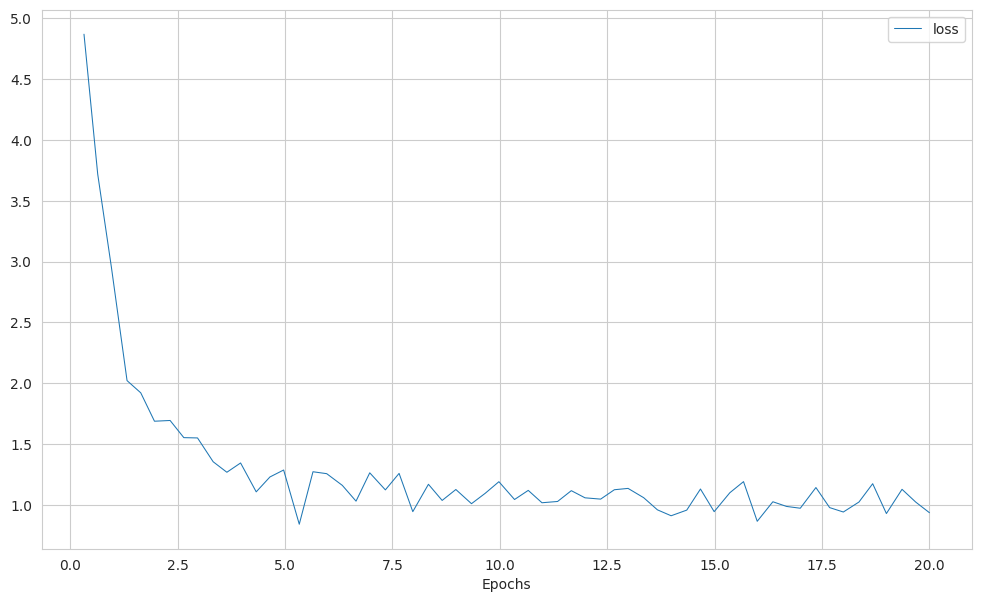

In [12]:
%run tools/analysis_tools/analyze_logs.py plot_curve {latest_config} --keys loss --legend loss

plot curve of work_dirs/resnet101-csra_1xb16_voc07-448px_VOC/20250709_134105/vis_data/scalars.json, metric is multi-label/f1-score


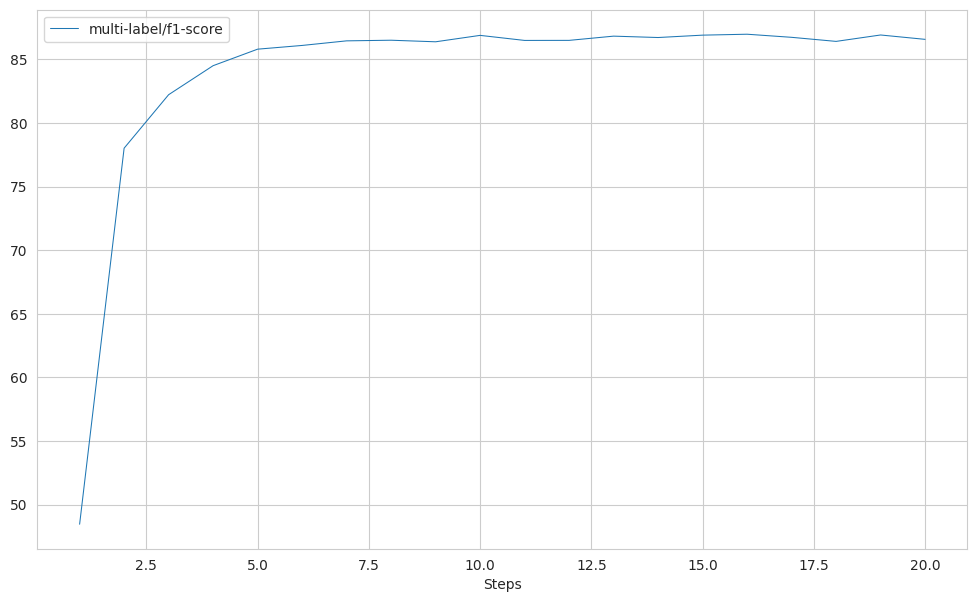

In [13]:
%run tools/analysis_tools/analyze_logs.py plot_curve {latest_config} --keys multi-label/f1-score --legend multi-label/f1-score

# Read the training log
Every epoch, the log prints current training status incluing Loss and learning rate(LR). <br>
and then current precision, recall <br>

In ideal scenario, training loss decreases and accuracy increases gradually throughout the training. <br> 
When it comes to the end of training, training loss would still decreases slightly, while accuracy stops improving, and it should be already satisfactory. <br>
 <br>
If training loss decreases and accuracy increases slowly, you may increase learning rate (eg double it) <br>
If both training loss and accuracy flutuate violently, you may decrease learning rate (eg half it) <br>
If accuracy is still improving at the end of training, you may increase number of epoch <br>
If training loss decreases while accuracy stagnates or worsens before getting satisfactory accuracy, you should add more samples or implement stronger augmentation, and ensure the two datasets are alike <br>
If both training loss and accuracy stagnates, and the accuracy is not satisfactory, you should consider choosing a more advanced or larger model <br>

# Augmentations

In our csra sample, there is a very simple augmentation strategy applied. As stated in <br>
train_pipeline:<br>
&nbsp;&nbsp;&nbsp;&nbsp;dict(crop_ratio_range=(0.7, 1.0,), scale=448, type='RandomResizedCrop'),<br>
&nbsp;&nbsp;&nbsp;&nbsp;dict(direction='horizontal', prob=0.5, type='RandomFlip'),<br>
To create more augmentation, we can add it into train_pipeline <br>
for example, copy the below code (choose either built-in augmentation or Albumentations augmentation) and paste to the above script of training cfg, right above <br>
#------------------------------------------------------ <br>
config=f'./configs/csra/resnet101-csra_1xb16_voc07-448px_VOC.py' <br>

for more augmentation, you can refer to <br>
https://mmpretrain.readthedocs.io/en/stable/api/data_process.html <br>
for more augmentation in Albumentations, you can refer to <br>
https://github.com/albumentations-team/albumentations <br>
You can view how images are augmented with the script below, the images are saved in the folder visualization/ <br>

# Inference
Here we inference on a single image <br>

In [14]:
# Inference our trained model
from mmpretrain.apis import ImageClassificationInferencer

In [15]:
import os
def get_latest_checkpoint(base_dir):
    ckpt_file = os.path.join(base_dir, "last_checkpoint")
    if os.path.exists(ckpt_file):
        with open(ckpt_file, "r") as f:
            relative_ckpt_path = f.readline().strip()
            full_ckpt_path = os.path.join(base_dir, relative_ckpt_path)
            if os.path.exists(full_ckpt_path):
                return full_ckpt_path
    return None

# the logs stored in work_dirs/resnet101_8xb32_planenbike/
latest_ckpt = get_latest_checkpoint("work_dirs/resnet101-csra_1xb16_voc07-448px_VOC/")
print(f"Using checkpoint: {latest_ckpt}")

Using checkpoint: /home/test/carasml/classification/mm_Resnet/mmpretrain/work_dirs/resnet101-csra_1xb16_voc07-448px_VOC/epoch_20.pth


In [16]:
# find the trained model saved in "work_dirs/" and revise the location
# revise the name of .py for your own project
inferencer = ImageClassificationInferencer('work_dirs/resnet101-csra_1xb16_voc07-448px_VOC/resnet101-csra_1xb16_voc07-448px_VOC.py', pretrained=latest_ckpt, device='cuda')

Loads checkpoint by local backend from path: /home/test/carasml/classification/mm_Resnet/mmpretrain/work_dirs/resnet101-csra_1xb16_voc07-448px_VOC/epoch_20.pth


Predicted classes: ['chair', 'diningtable', 'sofa']
Prediction scores: [np.float32(0.98757684), np.float32(0.52675617), np.float32(0.9553207)]


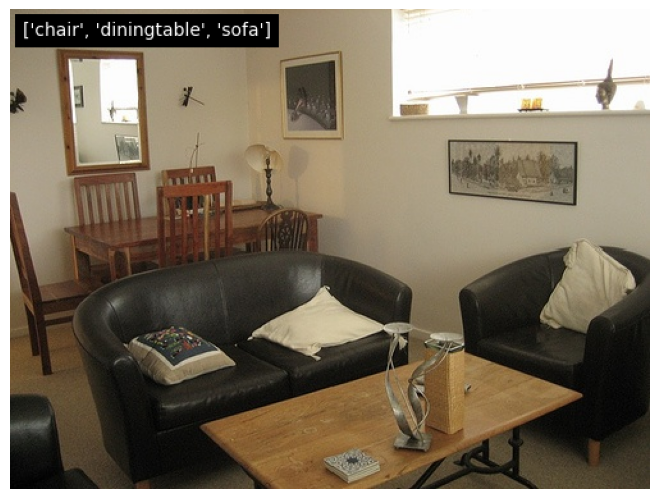

In [17]:
# pick an image
img = 'VOC2007/test/001163.jpg'
# inference
result = inferencer(img)
# plot
from mmengine.visualization import Visualizer
scores = result[0]['pred_scores']

# You can set a threshold to determine positive predictions
threshold = 0.5
predicted_labels = np.where(scores > threshold)[0] # Get indices of classes above threshold

# Get class names (if available in the model)
class_names = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
predicted_class_names = [class_names[idx] for idx in predicted_labels]
print("Predicted classes:", predicted_class_names)
scores = [scores[idx] for idx in predicted_labels]
print("Prediction scores:", scores)
image = mmcv.imread(img, channel_order='rgb')
pred_print = f'{predicted_class_names}'
visualizer = Visualizer(image=image)
visualizer.draw_texts(pred_print, torch.tensor([10, 10]), font_sizes=10, colors='white', bboxes=dict(facecolor='black', linewidth=0, alpha=1))
visualizer.show()

# Validation
revise the name of .py and .pkl for your own project <br>
it will save the prediction of all samples in validation set in a pkl

In [18]:
%run tools/test.py work_dirs/resnet101-csra_1xb16_voc07-448px_VOC/resnet101-csra_1xb16_voc07-448px_VOC.py {latest_ckpt} --out output/resnet101-csra_1xb16_voc07-448px_VOC.pkl

07/09 13:54:56 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 2028222144
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8/
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,c

In [19]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

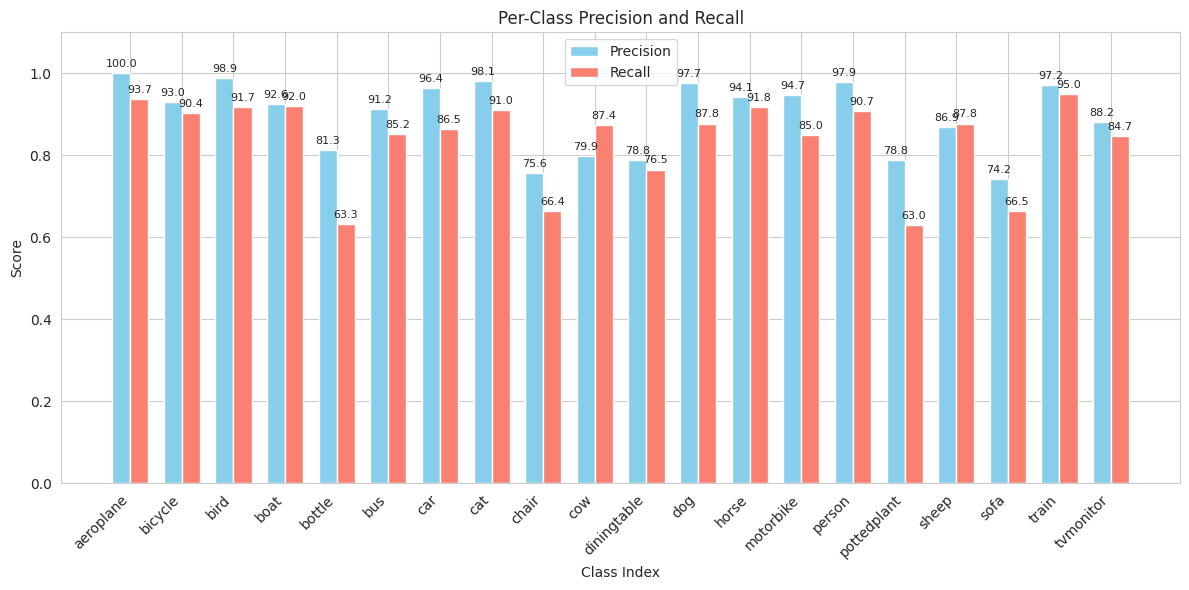

In [20]:
# plot precision recall
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
file_path = "output/resnet101-csra_1xb16_voc07-448px_VOC.pkl"
with open(file_path, 'rb') as f:
    data = pickle.load(f)
num_classes = data[0]['num_classes']
tp = np.zeros(num_classes)
fp = np.zeros(num_classes)
fn = np.zeros(num_classes)

for item in data:
    gt = set(item['gt_label'].tolist())
    pred = set(item['pred_label'].tolist())

    for c in range(num_classes):
        if c in pred:
            if c in gt:
                tp[c] += 1
            else:
                fp[c] += 1
        if c in gt and c not in pred:
            fn[c] += 1

# Avoid divide-by-zero
precision = np.divide(tp, tp + fp, out=np.zeros_like(tp), where=(tp + fp) != 0)
recall = np.divide(tp, tp + fn, out=np.zeros_like(tp), where=(tp + fn) != 0)

# Plot
x = np.arange(num_classes)
width = 0.35

# Assuming precision, recall, class_names, and x (np.arange) are already defined
plt.figure(figsize=(12, 6))

# Plot bars
bars1 = plt.bar(x - width/2, precision, width, label='Precision', color='skyblue')
bars2 = plt.bar(x + width/2, recall, width, label='Recall', color='salmon')

# Annotate each bar with its value
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height*100:.1f}', 
             ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height*100:.1f}', 
             ha='center', va='bottom', fontsize=8)

# Customize plot
plt.xticks(x, class_names, rotation=45, ha='right')
plt.xlabel('Class Index')
plt.ylabel('Score')
plt.title('Per-Class Precision and Recall')
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()